<a href="https://colab.research.google.com/github/tommy-swimmer/mlearn/blob/master/reference_finetuning_adapted.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Credit: [Csho33](https://github.com/csho33/bacteria-ID)

This is code that was developed by the credited GitHub profile above. I've added some plot function and google drive functionality for my own purposes.

# Fine-tuning on the reference dataset
In this notebook, we'll demonstrate fine-tuning a pre-trained CNN on the 30-isolate classification task shown in Figure 2. In this example, fine-tuning serves to update the CNN to new measurement parameters. This code illustrates the procedure described in the `CNN architecture & training details` section in the Methods. Note that for speed and clarity, this demo only trains on a single randomly selected train and validation split.

In [ ]:
# Mounting google drive to access files. 
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
# Showing the directory where the data is housed.
!ls /content/gdrive/'My Drive/ML Group/Datasets/data'

wavenumbers.npy     X_finetune.npy   y_2018clinical.npy  y_reference.npy
X_2018clinical.npy  X_reference.npy  y_2019clinical.npy  y_test.npy
X_2019clinical.npy  X_test.npy	     y_finetune.npy


In [ ]:
# Moving into directory where .py functions will be needed.
% cd /content/gdrive/'My Drive/ML Group/Individual Work/Tommy/stanford_directory'

/content/gdrive/My Drive/ML Group/Individual Work/Tommy/stanford_directory


In [ ]:
# Verifying that directory location is correct.
!pwd

/content/gdrive/My Drive/ML Group/Individual Work/Tommy/stanford_directory


## Loading data
The first step is to load the fine-tuning dataset.

In [ ]:
from time import time
t00 = time()
import numpy as np

import matplotlib.pyplot as plt # I added this.
import pandas as pd # I also added this from original.

In [ ]:
X_fn = '/content/gdrive/My Drive/ML Group/Datasets/data/X_finetune.npy'
y_fn = '/content/gdrive/My Drive/ML Group/Datasets/data/y_finetune.npy'
X = np.load(X_fn)
y = np.load(y_fn)
print(X.shape, y.shape)

(3000, 1000) (3000,)


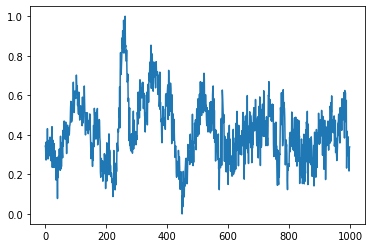

In [ ]:
plt.plot(X[1]) # Looks like a normalized spectral data sample?

## Loading pre-trained CNN
Now we set up a ResNet CNN and load weights that we previously trained for the 30-isolate task using the full training dataset. 

In [ ]:
from resnet import ResNet 
import os
import torch

In [ ]:
# CNN parameters
layers = 6
hidden_size = 100
block_size = 2
hidden_sizes = [hidden_size] * layers
num_blocks = [block_size] * layers
input_dim = 1000
in_channels = 64
n_classes = 30
os.environ['CUDA_VISIBLE_DEVICES'] = '{}'.format(0)
cuda = torch.cuda.is_available()
pretrain_dir = '/content/gdrive/My Drive/ML Group/Individual Work/Tommy/stanford_directory/pretrained_model.ckpt'

In [ ]:
# Load trained weights for demo
cnn = ResNet(hidden_sizes, num_blocks, input_dim=input_dim,
                in_channels=in_channels, n_classes=n_classes)
if cuda: cnn.cuda()
cnn.load_state_dict(torch.load(
    './pretrained_model.ckpt', map_location=lambda storage, loc: storage))

<All keys matched successfully>

## Fine-tuning
Now we can fine-tune the pre-trained CNN on the new fine-tuning dataset. In the experiments reported in the paper, we fine-tune across 5 randomly selected train and validation splits, but here we show just one split for clarity. We also only train for one epoch here in the interest of time. To train the CNN to convergence, we recommend setting the number of epochs to ~30.

In [ ]:
from datasets import spectral_dataloader
from training import run_epoch
from torch import optim

### Train/val split
We split the fine-tuning dataset into train and validation sets. We randomly sample 10% of the dataset to use as a validation set.

In [ ]:
p_val = 0.1
n_val = int(3000 * p_val)
idx_tr = list(range(3000))
np.random.shuffle(idx_tr)
idx_val = idx_tr[:n_val]
idx_tr = idx_tr[n_val:]

In [ ]:
# Fine-tune CNN
epochs = 30 # Change this number to ~30 for full training
batch_size = 10
t0 = time()
# Set up Adam optimizer
optimizer = optim.Adam(cnn.parameters(), lr=1e-3, betas=(0.5, 0.999))
# Set up dataloaders
dl_tr = spectral_dataloader(X, y, idxs=idx_tr,
    batch_size=batch_size, shuffle=True)
dl_val = spectral_dataloader(X, y, idxs=idx_val,
    batch_size=batch_size, shuffle=False)
# Fine-tune CNN for first fold
best_val = 0
no_improvement = 0
max_no_improvement = 5
print('Starting fine-tuning!')
for epoch in range(epochs):
    print(' Epoch {}: {:0.2f}s'.format(epoch+1, time()-t0))
    # Train
    acc_tr, loss_tr = run_epoch(epoch, cnn, dl_tr, cuda,
        training=True, optimizer=optimizer)
    print('  Train acc: {:0.2f}'.format(acc_tr))
    # Val
    acc_val, loss_val = run_epoch(epoch, cnn, dl_val, cuda,
        training=False, optimizer=optimizer)
    print('  Val acc  : {:0.2f}'.format(acc_val))
    # Check performance for early stopping
    if acc_val > best_val or epoch == 0:
        best_val = acc_val
        no_improvement = 0
    else:
        no_improvement += 1
    if no_improvement >= max_no_improvement:
        print('Finished after {} epochs!'.format(epoch+1))
        break

print('\n This demo was completed in: {:0.2f}s'.format(time()-t00))

Starting fine-tuning!
 Epoch 1: 0.00s
  Train acc: 89.41
  Val acc  : 91.00
 Epoch 2: 7.36s
  Train acc: 94.78
  Val acc  : 91.67
 Epoch 3: 14.75s
  Train acc: 97.07
  Val acc  : 91.00
 Epoch 4: 22.29s
  Train acc: 98.56
  Val acc  : 90.00
 Epoch 5: 29.54s
  Train acc: 98.93
  Val acc  : 91.33
 Epoch 6: 36.96s
  Train acc: 99.26
  Val acc  : 92.00
 Epoch 7: 44.18s
  Train acc: 99.52
  Val acc  : 92.00
 Epoch 8: 51.53s
  Train acc: 99.78
  Val acc  : 94.00
 Epoch 9: 58.91s
  Train acc: 99.70
  Val acc  : 93.00
 Epoch 10: 66.53s
  Train acc: 99.67
  Val acc  : 91.33
 Epoch 11: 73.74s
  Train acc: 98.93
  Val acc  : 92.67
 Epoch 12: 81.03s
  Train acc: 99.93
  Val acc  : 93.00
 Epoch 13: 88.34s
  Train acc: 100.00
  Val acc  : 92.67
Finished after 13 epochs!

 This demo was completed in: 186.65s


The accuracies seen here are not representative of the accuracies achieved when training on the full dataset until convergence. To do this, increase the number of epoches. This code demonstrates how a pre-trained CNN can be fine-tuned and evaluated using randomly selected train/validation splits.